In [1]:
import scipy.ndimage as spi
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from astropy.io import fits, ascii
import astropy.units as u

import simcado

# Observing an Imperial Star Destroyer with SimCADO
The goal here is to work out how close the imperial star destroyer (ISD) needs to be for us to be able to recognise that we are looking at a star destroyer. I have taken an image of an ISD from here - http://star-wars-and-mlpfim.wikia.com/wiki/Imperial-II_class_Star_Destroyer


## Image
The ISD is approximately a mile long (1600m) [wookipedia]. In this image, neglecting projection effects, the star destoryer is 1600 pixels long, ergo we have a plate scale of 1m2/px

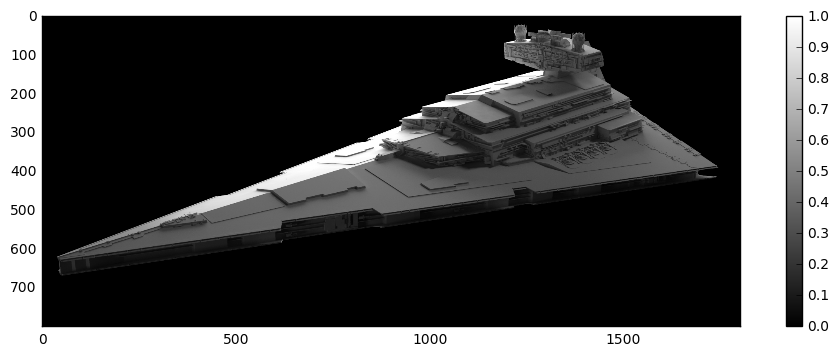

In [2]:
im = plt.imread("./Imperial-class_Star_Destroyer.jpg")/255.
plt.figure(figsize=(12,4))
plt.imshow(im[:,:,0], cmap="gray")
plt.colorbar()

The MICADO zoom mode has a pixel scale of 1.5mas, therefore we need to know at what distance 1 meter is 1.5mas. Basic trigonometry: 

$tan(\theta) = \frac{opposite}{adjacent} $ 

or 

$adj = \frac{opp}{tan(\theta)} $

In [3]:
theta = 1.5*u.mas
opp = 1*u.m
adj = opp / np.tan(theta)
adj.to(u.km)

<Quantity 137509.87083139757 km>

Given the distance to the moon is on average around 384000 km, we'll have to reduce the resolution a bit. 20x further away 
would be 2.75 million km, or roughly a twentieth of the distance between Mars and Earth at Mars's closest point to Earth (0.37 AU). We need to remember to conserve flux here. The total amount of light being reflected is constant, even though 

0.05


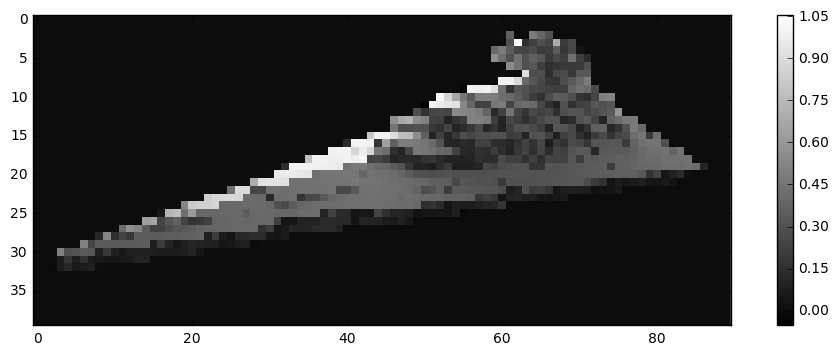

In [12]:
factor = 1/20. # (adj / (384400*u.km)).si.value
print(factor)
im_10x = spi.zoom(im[:,:,0], factor)
im_moon = spi.zoom(im[:,:,0], 0.35)
plt.figure(figsize=(12,4))
plt.imshow(im_10x, cmap="gray", interpolation="none")
plt.colorbar()

Now lets put this through SimCADO to see if the ISD is still visible. First we need to convert the image to a source object. To do that we need to know the surface brightness of the star destroyer.

## Flux

If we assume it to be sitting at a distance of 2.75 million km, or approximately 0.018 AU, from Earth. With a length of 1.6km, the star destroyer is similar in size to the near earth asteroid 7341 (1991 VK), which will pass by the earth at a distance of around 0.006AU on the 25th of January, 2017 (http://neo.jpl.nasa.gov/ca/). It has a H-band magnitude of 16.7 at a distance of 1 AU. 

The ISD for it's part will be ~50 times closer and so 2500 brighter than H=16.7. However this flux is spread over the full area of the image. To get the a "unit" flux, we will sum the pixel values in the image and then divide the H-band flux by this factor. Thus an image pixel with the value of 1 will be emitting a unit of flux.

For the ISD we will also assume an albedo of 0.9 (they're made of aluminum), which further boosts the flux of the ISD over the asteroid (albedo ~0.3) by a factor of 3

In [5]:
g2v = simcado.source.star(mag=16.7, filter_name="H", spec_type="G2V")
h_filter = simcado.optics.get_filter_curve("H")

flux_neo = (g2v * h_filter).photons_in_range() * g2v.units
print("H-band flux from a G2V star with H=16.7:", flux_neo)
flux_isd = (0.9/0.3) * ((1*u.au)/(20*adj)).si * flux_neo
print("Total flux from ISD:", flux_isd)

# There are np.sum(im10x) flux units in the image, so we need to divide the total flux by this number
unit_flux_isd = flux_isd / np.sum(im_10x)
print("ISD unit flux:", unit_flux_isd)

H-band flux from a G2V star with H=16.7: [ 602.10763448] ph / (m2 s)
Total flux from ISD: [ 98255.51377371] ph / (m2 s)
ISD unit flux: [ 335.4640439] ph / (m2 s)


We now create a G2V spectrum for the star destroyer because we assume it reflects the sun's light. If we assume each pixel in the ISD is a point source, we can assign a point source spectrum to the ISD in SimCADO. However, the ISD's per pixel magnitude is 0.63 magnitudes weaker than the NEO. 

``factor = 2.5*np.log10(flux_neo/unit_flux_isd)``

In [6]:
lam, spec = simcado.source.SED(spec_type="G2V", filter_name="H", magnitude=16.7+0.63)
pix_res = 0.0015
src_isd = simcado.source.source_from_image(im_10x, lam, spec, plate_scale=pix_res, flux_threshold=0.1)

## Observing the star destroyer
Now that we have a SimCADO source object, we can run it though SimCADO and see if it really is visible

In [10]:
hdu, (cmd, opt, fpa) = simcado.run(src_isd, mode="zoom", detector_layout="small", return_internals=True, 
                                   INST_FILTER_TC="H", OBS_EXPTIME=1)
#hdu = simcado.run(src_isd, mode="zoom", cmds=cmd, opt_train=opt, detector_layout="small")

Using PSF: C:\Program Files\Anaconda3\lib\site-packages\simcado\data\PSF_SCAO.fits
 id x_cen y_cen x_len y_len
--- ----- ----- ----- -----
  0     0     0  1024  1024
Creating 2 layer(s) per chip
1 chip(s) will be simulated
Chip ID: 0 - Creating layer between [um]: 1.438 1.678
Chip ID: 0 - Creating layer between [um]: 1.678 1.815
Reading out chip 0


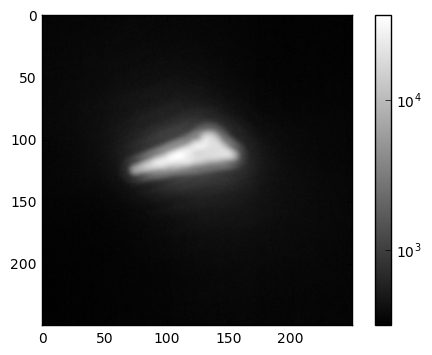

In [11]:
plt.imshow(hdu[0].data[400:650, 400:650], norm=LogNorm(), cmap="gray")
plt.colorbar()

At 2.75 million km the star destroyer will be quite visible, assuming it has an absolute magnitude of H=16.7 at 1 pc. Now f we were to place it at the distance of the moon, we can start to see structure coming out on the surface

Using PSF: C:\Program Files\Anaconda3\lib\site-packages\simcado\data\PSF_SCAO.fits
 id x_cen y_cen x_len y_len
--- ----- ----- ----- -----
  0     0     0  1024  1024
Creating 2 layer(s) per chip
1 chip(s) will be simulated
Chip ID: 0 - Creating layer between [um]: 1.438 1.678
Chip ID: 0 - Creating layer between [um]: 1.678 1.815
Reading out chip 0


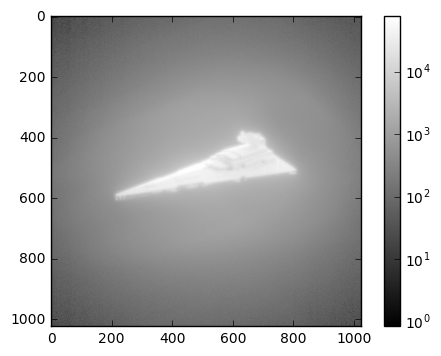

In [16]:
src_isd_moon = simcado.source.source_from_image(im_moon, lam, spec, plate_scale=pix_res, flux_threshold=0.1)
hdu = simcado.run(src_isd_moon, mode="zoom", detector_layout="small", INST_FILTER_TC="H", OBS_EXPTIME=1)

In [2]:
plt.imshow(hdu[0].data, norm=LogNorm(), cmap="gray", vmin=np.median(hdu[0].data))
plt.colorbar()

NameError: name 'hdu' is not defined

In [1]:
import scipy.ndimage as spi
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from astropy.io import fits, ascii
import astropy.units as u

import simcado